In [1]:
import wfdb
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv1D
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, optimizers

from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

warnings.filterwarnings("ignore") 

In [2]:
def load_ecg(file):    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    # extracting the signal
    p_signal = record.p_signal
    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
   
    return p_signal, atr_sym, atr_sample

win_size = 200
def baseline_remove(p_signal, win_size):
    avg_p_signal = []
    
    for i in range(len(p_signal)-win_size):
        subsample0 = p_signal[i:i+win_size,0]
        subsample1 = p_signal[i:i+win_size,1]
        mean0 = np.mean(subsample0)
        mean1 = np.mean(subsample1)
        avg_p_signal.append([mean0,mean1])
        
    avg_p_signal = np.array(avg_p_signal)
    p_signal_removed_baseline = p_signal[100:len(p_signal)-100,]-avg_p_signal
    
    return p_signal_removed_baseline, avg_p_signal

neighbor = 90 # ~0.25s
def normalization(p_signal_removed_baseline, neighbor):
    p_signal_norm = []
    norm_signal = []
    
    for i in range(neighbor, len(p_signal_removed_baseline)-neighbor):
        subsample0 = p_signal_removed_baseline[i-neighbor:i+neighbor,0]
        subsample1 = p_signal_removed_baseline[i-neighbor:i+neighbor,1]
        nor0 = max(np.abs(np.max(subsample0)),np.abs(np.min(subsample0)))
        nor1 = max(np.abs(np.max(subsample1)),np.abs(np.min(subsample1)))
        norm_signal.append([nor0, nor1])
    
    norm_signal = np.array(norm_signal)
    norm_signal0 = norm_signal[:,0]
    norm_signal1 = norm_signal[:,1]

    mean_norm0 = np.mean(norm_signal[:,0])/2
    mean_norm1 = np.mean(norm_signal[:,1])/2

    norm_signal0 = np.where(norm_signal0>mean_norm0, norm_signal0, mean_norm0)
    norm_signal1 = np.where(norm_signal1>mean_norm1, norm_signal1, mean_norm1)
    
    len_rmbl = len(p_signal_removed_baseline)
    p_signal_norm_0 = p_signal_removed_baseline[neighbor:len_rmbl-neighbor,0]/norm_signal0
    p_signal_norm_1 = p_signal_removed_baseline[neighbor:len_rmbl-neighbor,1]/norm_signal1
    
    return p_signal_norm_0, p_signal_norm_1, norm_signal

def assign_tag(p_signal, atr_sample):
    # Define a window size for segmenting the signal
    window_size = 28  # Adjust as needed
    # Assign tag
    tag = np.zeros_like(p_signal)
    for i in atr_sample:
        tag[i - window_size // 2:i + window_size // 2] = 1
        
    return tag

# plot signal and tag
def detect_and_segment_r_peaks2(p_signal, atr_sample, Fst_sam, Sam_num):
    # Define a window size for segmenting the signal
    window_size = 28  # Adjust as needed
    
    # Create segments around R-peaks for Signal 1
    segments1 = [p_signal[peak - window_size // 2: peak + window_size // 2] for peak in atr_sample]
    
    # Plot the original signal for the first 1000 samples
    plt.figure(figsize=(20, 6))
    plt.plot(p_signal[Fst_sam:Sam_num], label='Original Signal (First 1000 Samples)', color='blue')
    
    # Plot the segments for Signal 1
    tag = np.zeros_like(p_signal)
    for i in atr_sample:
        tag[i - window_size // 2:i + window_size // 2] = 1
    
    for i, segment in enumerate(segments1):
        if atr_sample[i] < Sam_num and atr_sample[i] > Fst_sam:
            x_values = np.arange(len(segment)) + atr_sample[i] - window_size // 2
            plt.plot(x_values, segment, label=f'Segment {i + 1}', color='red')
            
        else: continue
    plt.plot(tag[Fst_sam:Sam_num])

    # Customize labels, title, legend, and grid for the plot
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title('Original Signal and ECG Segments')
    plt.grid(True)
    plt.show()
    
# create data
def create_sequences(features, labels, n_steps, num_classes):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features[i:i + n_steps].reshape(n_steps, 1))
        y.append(to_categorical(np.max(labels[i:i + n_steps]), num_classes=num_classes))
    return np.array(X), np.array(y)

In [3]:
data = '/kaggle/input/mitbih/mit-bih-arrhythmia-database-1.0.0/'
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

In [4]:
# Creating a Empty Dataframe
dataf = pd.DataFrame()

# Reading all .atr files 
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    
    #the non-beat and beat annotations codes extarct with wfdb.rdann
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol

    # count the num occ of each unique value in Numpy array
    values, counts = np.unique(sym, return_counts=True)

    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    
    # Concatenating two data frames
    dataf = pd.concat([dataf, df_sub],axis = 0)

#for viewing data frame    
dataf.head()
dataf.symbol.unique()

array(['+', 'A', 'N', 'V', 'Q', '|', '~', '/', 'f', 'F', 'j', 'x', 'L',
       'a', 'J', 'R', '!', 'E', '[', ']', 'S', '"', 'e'], dtype=object)

In [5]:
# Accessing the ecg points for 
file = data + patients[3]

p_signal, atr_sym, atr_sample = load_ecg(file)

In [6]:
# Analysing annotations value counts for a single record
values, counts = np.unique(sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [7]:
# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Normal Beat Symbols
normal = ['N']

In [8]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index
#sym location 

[418275, 489639]

In [9]:
atr_sample

array([    21,    265,    575, ..., 649195, 649534, 649875])

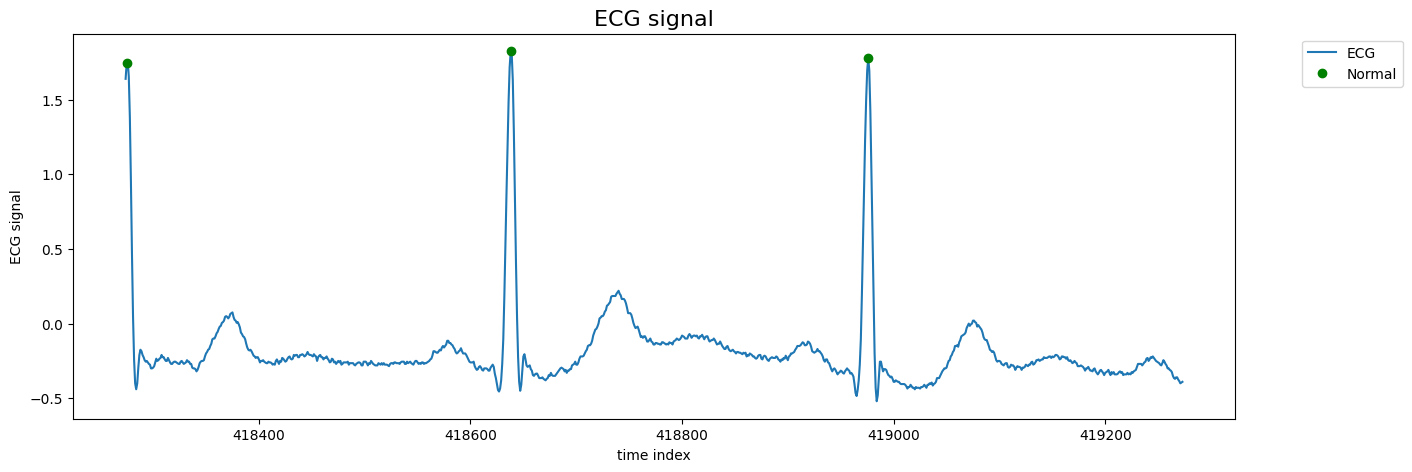

In [10]:
# Generating evenly spaced values
x = np.arange(len(p_signal))
plt.figure(figsize=(15,5))

#1st Graph
# plt.subplot(2,2,1)
#crop operation
left = 418274
right = left+1000

# plt.plot(x[left:right],p_signal[left:right,0],'-',label='ECG',)
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ECG',)

plt.plot(x[[i for i in atr_sample if left<i<right]],p_signal[[i for i in atr_sample if left<i<right],0],'go',label ='Normal')
# plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='Abnormal')
# plt.xlim(left,right)
# plt.ylim(p_signal.min()-0.05,p_signal.max()+0.05)


plt.legend(bbox_to_anchor = (1.15,1), loc = 'upper right')
plt.title('ECG signal', fontsize=16)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.show()

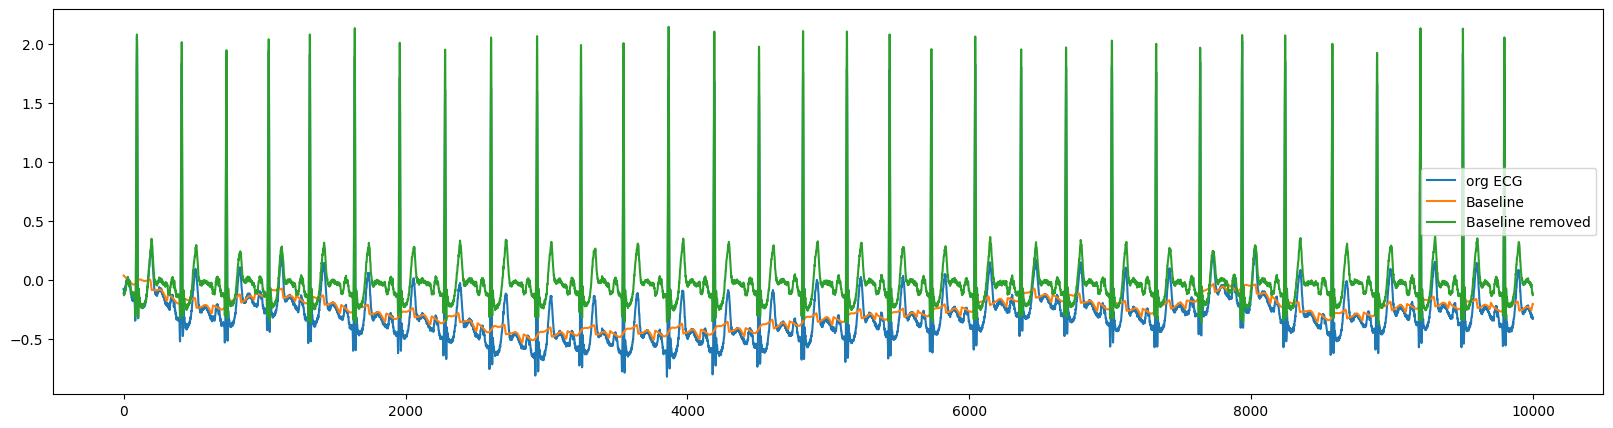

In [14]:
p_signal_removed_baseline, avg_p_signal = baseline_remove(p_signal, win_size)

plt.figure(figsize = (20,5))
idx = 382000
plt.plot(p_signal[idx+100:idx+10100,0],'-',label='org ECG')
plt.plot(avg_p_signal[idx:idx+10000,0], label = "Baseline")
plt.plot(p_signal_removed_baseline[idx:idx+10000,0], label = 'Baseline removed')
plt.legend()

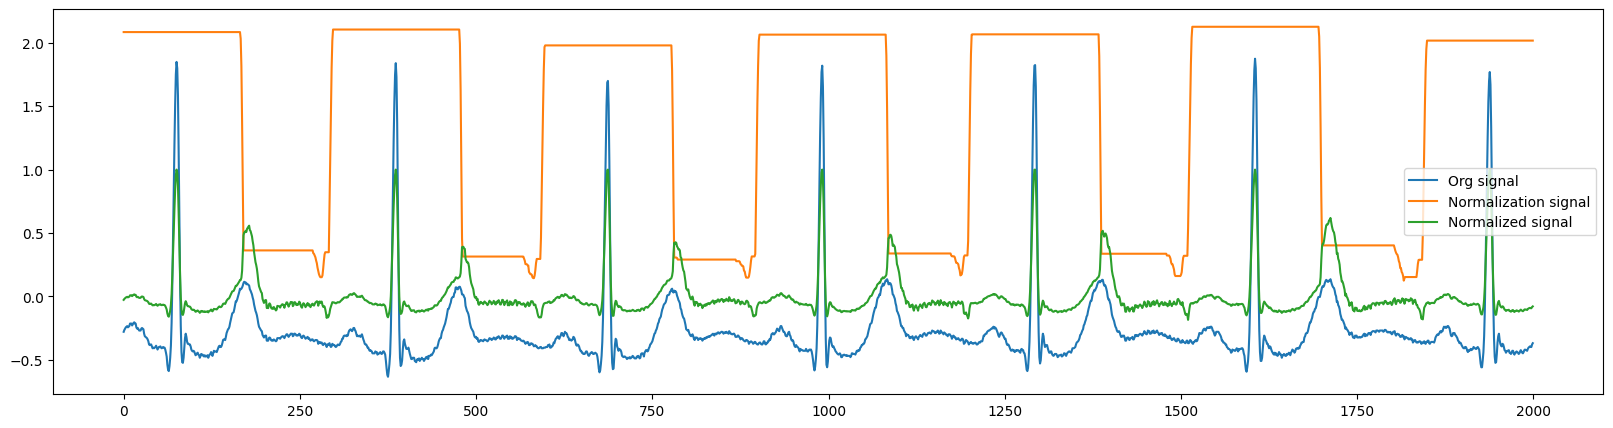

In [20]:
plt.figure(figsize = (20,5))
p_signal_norm_0, p_signal_norm_1, norm_signal = normalization(p_signal_removed_baseline, neighbor)

idx = 2000
plt.plot(p_signal[190:idx+190,0], label = "Org signal")
plt.plot(norm_signal[:idx,0], label = "Normalization signal")
plt.plot(p_signal_norm_0[:idx], label = "Normalized signal")
plt.legend()

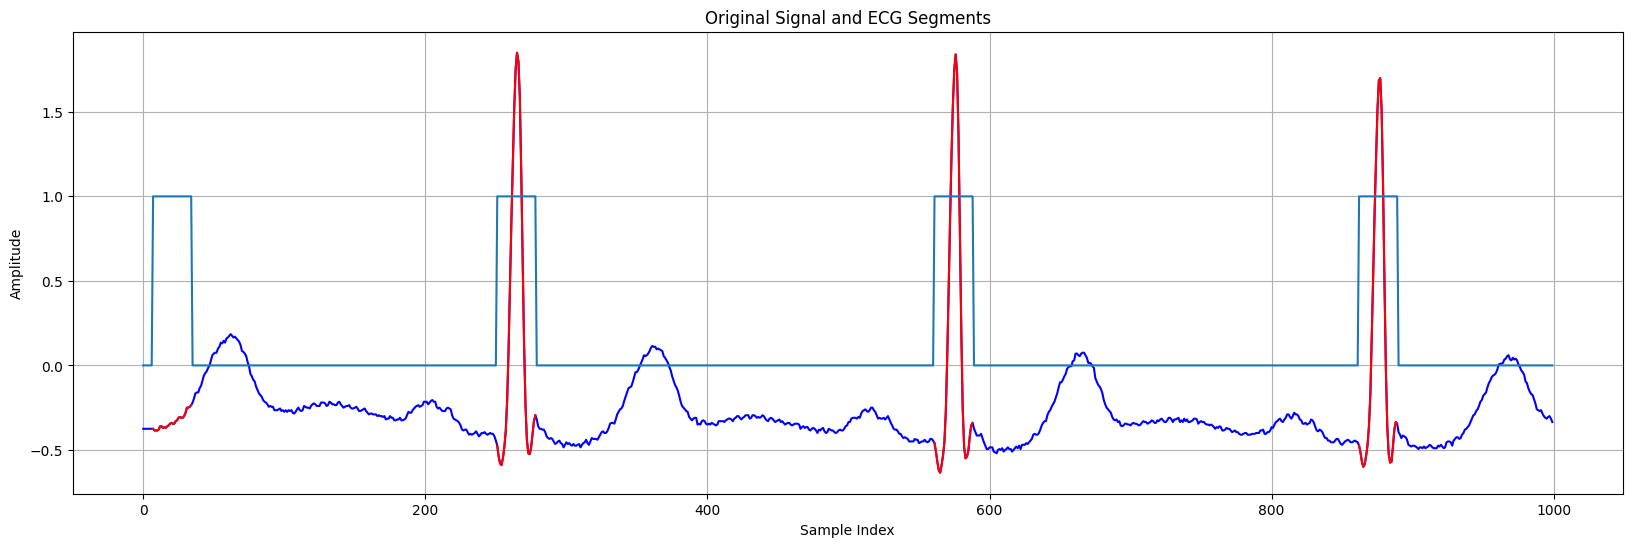

In [21]:
detect_and_segment_r_peaks2(p_signal[:,0], atr_sample, 0, 1000)

In [32]:
def prepare_data(data, patients, flag):
    X_main = []
    y_main = []
    for i in range(6):
        if i % 2 == flag:
            file = data + patients[i]
            # read signal
            p_signal, atr_sym, atr_sample = load_ecg(file)
            
            # remove baseline
            p_signal_removed_baseline, _ = baseline_remove(p_signal, win_size)
            
            # normalization
            p_signal_norm_0, p_signal_norm_1, _ = normalization(p_signal_removed_baseline, neighbor)
            
            # create tag
            tag = assign_tag(p_signal, atr_sample)
            
            # create dataset
            X_train = p_signal_norm_0
            y_train = tag[190:len(tag)-190]
            X, y = create_sequences(X_train, y_train, 145, 2)
            
            # concat with previous set
            if len(X_main) == 0:
                X_main = X
                y_main = y
            else:
                X_main = np.concatenate((X_main, X), axis=0)
                y_main = np.concatenate((y_main, y), axis=0)
    return X_main, y_main

In [40]:
X_train, y_train = prepare_data(data, patients, 0)
print(X_train.shape)
print(y_train.shape)

(1948425, 145, 1)
(1948425, 2)


In [41]:
# Open a file and use dump() 
with open('train_data.pkl', 'wb') as file: 
	# A new file will be created 
	pickle.dump([X_train, y_train], file) 

In [42]:
X_test, y_test = prepare_data(data, patients, 1)
print(X_test.shape)
print(y_test.shape)

(1948425, 145, 1)
(1948425, 2)


In [43]:
# Open a file and use dump() 
with open('test_data.pkl', 'wb') as file: 
	# A new file will be created 
	pickle.dump([X_test, y_test], file) 

In [44]:
!ls

state.db  test_data.pkl  train_data.pkl


In [4]:
with open('train_data.pkl', 'rb') as file:
	X_train, y_train = pickle.load(file) 

In [12]:
with open('test_data.pkl', 'rb') as file:
	X_test, y_test = pickle.load(file) 

In [5]:
print(X_train.shape)
print(y_train.shape)

(1948425, 145, 1)
(1948425, 2)


In [13]:
print(X_test.shape)
print(y_test.shape)

(1948425, 145, 1)
(1948425, 2)


In [6]:
model = models.Sequential()
# Input layer
model.add(layers.InputLayer(input_shape=(145, 1)))
# C1 layer
model.add(layers.Conv1D(32, 5, strides=1, activation='relu'))
model.add(layers.Dropout(0.5))
# P1 layer
model.add(layers.MaxPooling1D(3, strides=2))
# C2 layer
model.add(layers.Conv1D(32, 5, strides=1, activation='relu'))
model.add(layers.Dropout(0.5))
# Flatten the output
model.add(layers.Flatten())
# F1 layer
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
# F2 layer
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
# Output layer
model.add(layers.Dense(2, activation='softmax'))

# Compile the model with SGD optimizer
sgd = optimizers.SGD(learning_rate=0.005, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 141, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 141, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 70, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 66, 32)         │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 66, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2112)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,163,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,694,882 (10.28 MB)

 Trainable params: 2,694,882 (10.28 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train,y_train,validation_split=0.2,epochs=3,batch_size=128,verbose=1)

Epoch 1/3
   53/12178 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.5648 - loss: 0.6573  

I0000 00:00:1717140921.781144      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12178/12178 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.9394 - loss: 0.1518 - val_accuracy: 0.9595 - val_loss: 0.1286
Epoch 2/3
12178/12178 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9790 - loss: 0.0644 - val_accuracy: 0.9711 - val_loss: 0.0912
Epoch 3/3
12178/12178 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9810 - loss: 0.0570 - val_accuracy: 0.9734 - val_loss: 0.0882


In [8]:
model.save("cnn_ecg_3ep.h5")

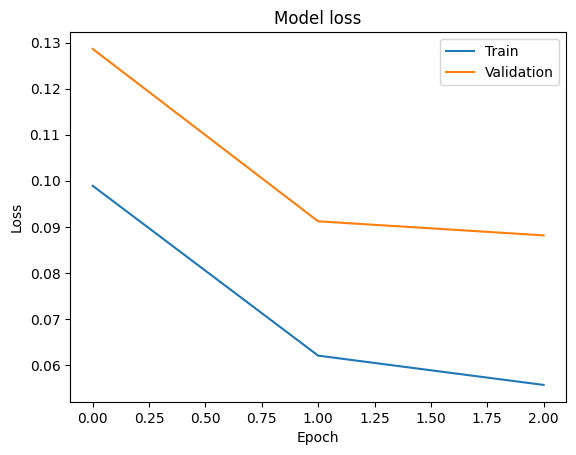

In [9]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

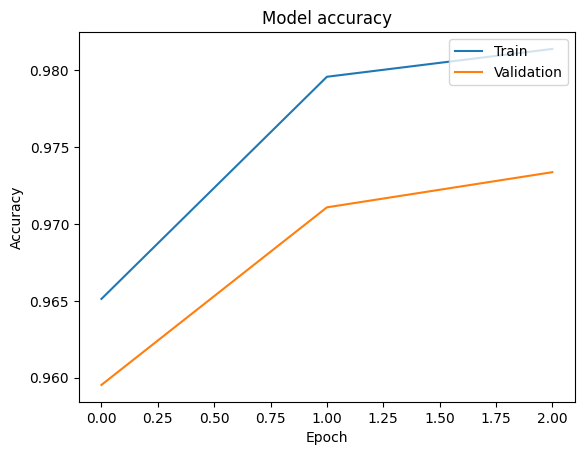

In [11]:
# Plot training & validation loss values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
idx = 100
accuracy = model.predict(X_test[:idx])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [23]:
real = np.argmax(y_test[:idx], axis = 1)
real

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
pre = np.argmax(accuracy, axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
acc = np.abs(real-pre)